<h1> Как рассказать историю с помощью данных

<h2>Описание проекта

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

## Список заданий

1. Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.
2. Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.
3. Для какого вида объекта общественного питания характерно сетевое распространение?
4. Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?
5. Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.
6. Выделите в отдельный столбец информацию об улице из столбца address .
7. Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?
8. Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

## Загрузка данных для обработки

Перед началом работы нужно загрузить необходимые библиотеки для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt                      
import requests
from io import BytesIO                                    # Загрузка библиотек
import warnings
warnings.filterwarnings("ignore")                         # Отключение предупреждений

Теперь загрузим данные и посмотрим базовую структуру.

In [2]:
rest_df = pd.read_csv('https://code.s3.yandex.net/datasets/rest_data.csv')    # Чтение данных из файла с сервера
rest_df.info()                                                                # Просмотр структуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В датафрейме обнаружены следующие столбцы:

* `id` — идентификатор объекта;
* `object_name` — название объекта общественного питания;
* `chain` — сетевой ресторан;
* `object_type` — тип объекта общественного питания;
* `address` — адрес;
* `number` — количество посадочных мест.

Для того, чтобы определить районы города, в которых находятся заведения, было выполнено извлечение данных в виде файлов:
 * по улицам - источник (https://data.mos.ru/classifier/7710168515-obshchemoskovskiy-klassifikator-ulits-moskvy-omk-001-2013-razdel-1/passport?versionNumber=1&releaseNumber=52);
 * по районам - источник (https://data.mos.ru/classifier/7710168515-obshchemoskovskiy-klassifikator-territorialnyh-edinits-moskvy-omk-002-2013-razdel-1/passport?versionNumber=1&releaseNumber=5).

Данные были извлечены в виде двух таблиц в формате `.csv`. Начнем с выгрузки данных по улицам из первого файла по ссылке.

In [3]:
msk_streets = '1NKDQnzXNnlZIm4a5ihNAuWbP7M6OnFyx3Woo176L4fE'                                       # ID файла
file_name1 = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(msk_streets)     # Ссылка для загрузки
rqst1 = requests.get(file_name1)                                                                   # Загрузка файла 
msk_st = pd.read_csv(BytesIO(rqst1.content))                               # Чтение данных из файла 
msk_st.info()                                                              # Просмотр структуры датафрейма

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5325 entries, 0 to 5324
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   UM_CODE      5325 non-null   object
 1   UM_NAMEF     5325 non-null   object
 2   UM_NAMES     5325 non-null   object
 3   UM_TRANS     5325 non-null   object
 4   UM_TYPE      5325 non-null   object
 5   UM_TM        1319 non-null   object
 6   UM_TE        5325 non-null   object
 7   UM_KLADR     5089 non-null   object
 8   global_id    5325 non-null   object
 9   UM_CODE_en   1 non-null      object
 10  UM_NAMEF_en  1 non-null      object
 11  UM_NAMES_en  1 non-null      object
 12  UM_TRANS_en  1 non-null      object
 13  UM_TYPE_en   1 non-null      object
 14  UM_TM_en     1 non-null      object
 15  UM_TE_en     1 non-null      object
 16  UM_KLADR_en  1 non-null      object
dtypes: object(17)
memory usage: 707.4+ KB


Теперь извлечем данные по районам из второго выгруженного файла в отдельный датафрейм. 

In [4]:
msk_districts = '1GD8QCD7vDN4suAEchg8JlyI37dFbbYPIHbQkSv-fTVA'                                      # ID файла
file_name2 = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(msk_districts)    # Ссылка для загрузки
rqst2 = requests.get(file_name2)                                                                    # Загрузка файла
msk_dst = pd.read_csv(BytesIO(rqst2.content))                              # Чтение данных из файла 
msk_dst.info()                                                             # Просмотр структуры датафрейма

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Kod         158 non-null    int64 
 1   Name        158 non-null    object
 2   global_id   158 non-null    int64 
 3   Latin_name  158 non-null    object
 4   Type        158 non-null    int64 
 5   Kod_okato   158 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 7.5+ KB


Загрузка данных завершена, переходим к предобработке данных.

## Предобработка данных

### Предобработка данных по адресам заведений

Проверим датафрейм на наличие пропусков, которые могут помешать обработке.

In [5]:
rest_df.isna().sum()                       # Просмотр количества пустых значений в столбцах

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Пропусков в столбцах нет. Теперь проверим на наличие дубликатов.

In [6]:
rest_df.duplicated().sum()                 # Определение количества явных дубликатов

0

Дубликаты не обнаружены. Можно переходить к поочередной проверке содержания столбцов, начиная со столбца с идентификаторами. 

In [7]:
display(len(rest_df['id'].unique()))                    # Просмотр количества уникальных заведений

15366

Всего обнаружено 15366 уникальных объектов. Посмотрим по столбцу с названиями количество оригинальных названий.

In [8]:
names = list(rest_df['object_name'].unique())           # Формирование списка уникальных названий
display(len(names))                                     # Просмотр количества названий

10393

Всего обнаружено 10393 уникальных названия. Поскольку количество названий меньше, чем общее количество объектов, это означает, что у сетевых ресторанов разные идентификаторы, но общее название заведения. Просмотрим список уникальных признаков сетевого ресторана на наличие необычных значений.

In [9]:
chain_list = list(rest_df['chain'].unique())            # Список с уникальными признаками сетевого ресторана
display((chain_list))                                   # Просмотр списка признаков

['нет', 'да']

Необычных статусов нет, только "да" или "нет". Определим уникальные типы заведений в датафрейме.

In [10]:
rest_types = list(rest_df['object_type'].unique())      # Формирование списка уникальных типов заведений
display(rest_types)                                     # Просмотр списка типов

['кафе',
 'столовая',
 'закусочная',
 'предприятие быстрого обслуживания',
 'ресторан',
 'кафетерий',
 'буфет',
 'бар',
 'магазин (отдел кулинарии)']

Всего 9 разных типов заведений. Осталось определить минимальное и максимальное количество мест в заведении. 

In [11]:
seat_cap = pd.Series(rest_df['number'].unique()).sort_values()        # Сортированный список с количеством мест в нем
display('Минимальное количество мест: {}'.format(seat_cap.min()))     # Минимальное значение
display('Максимальное количество мест: {}'.format(seat_cap.max()))    # Максимальное значение

'Минимальное количество мест: 0'

'Максимальное количество мест: 1700'

Скорее всего, нулевое значение вместимости характерно для магазинов, где просто не было предусмотрено место для приема пищи, а максимальная вместимость будет находиться в одной из столовых.

### Предобработка данных по улицам Москвы

Посмотрим первые строки датафрейма, чтобы найти нужные нам столбцы с данными, предварительно изменив регистр названий столбцов в нем.

In [12]:
msk_st.columns = msk_st.columns.str.lower()           # Приведение названий столбцов к нижнему регистру
msk_st.head()                                         # Просмотр первых 5 строк

,um_code,um_namef,um_names,um_trans,um_type,um_tm,um_te,um_kladr,global_id,um_code_en,um_namef_en,um_names_en,um_trans_en,um_type_en,um_tm_en,um_te_en,um_kladr_en
0,Код,Полное наименование,Сокращённое наименование,Транслитерация,Код вида,Код ОМК ТМ,Код ОМК ТЕ,Код КЛАДР,global_id,UM_CODE_en,UM_NAMEF_en,UM_NAMES_en,UM_TRANS_en,UM_TYPE_en,UM_TM_en,UM_TE_en,UM_KLADR_en
1,8880,1-й Ирининский переулок,1-й Ирининский пер.,Pervy'j Irininskij pereulok,2,NaN,102,"7,7E+16",58481065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8890,2-й Ирининский переулок,2-й Ирининский пер.,Vtoroj Irininskij pereulok,2,NaN,102,"7,7E+16",58481066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8891,3-й Ирининский переулок,3-й Ирининский пер.,Tretij Irininskij pereulok,2,NaN,102,"7,7E+16",58481067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8910,Иркутская улица,Иркутская ул.,Irkutskaya ulicza,1,NaN,406,"7,7E+16",58481068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В датафрейме есть нулевая строка с русскими наименованиям столбцов, она нам не потребуется. Из всех столбцов нам будут нужны только название улицы и код округа.

In [13]:
streets = msk_st[1:][['um_namef','um_te']]                    # Срез по столбцам без нулевой строки
streets.columns = ['street','district_code']                  # Переименование столбцов
streets.head()                                                # Просмотр первых 5 строк

,street,district_code
1,1-й Ирининский переулок,102
2,2-й Ирининский переулок,102
3,3-й Ирининский переулок,102
4,Иркутская улица,406
5,1-й Иртышский проезд,406


Проверим созданный срез на наличие пропусков.

In [14]:
streets.isna().sum()                     # Проверка на наличие пропусков

street           0
district_code    0
dtype: int64

Улицы и коды районов выделены, пропусков в них нет. Переходим к следующему файлу.

### Предобработка данных по районам Москвы

Как и в датафрейме по улицам, изменим регистры названий столбцов и посмотрим первые строки для определения необходимых столбцов.

In [15]:
msk_dst.columns = msk_dst.columns.str.lower()            # Приведение названий столбцов к нижнему регистру
msk_dst.head()                                           # Просмотр первых 5 строк

,kod,name,global_id,latin_name,type,kod_okato
0,100,Центральный административный округ,58703558,Czentral`ny'j administrativny'j okrug,2,45286000
1,101,район Арбат,58703559,rajon Arbat,3,45286552
2,102,Басманный район,58703560,Basmanny'j rajon,3,45286555
3,103,район Замоскворечье,58703561,rajon Zamoskvorech`e,3,45286560
4,104,Красносельский район,58703562,Krasnosel`skij rajon,3,45286565


В этом датафрейме нам понадобится срез данных по двум столбцам: код территориальной единицы и наименование района или округа. Дополнительно определим различные типы территориальных единиц, для чего просмотрим только часть датафрейма, выбрав из него каждую 8 строку в нем. 

In [16]:
districts = msk_dst[['kod','name']]                            # Срез данных по столбцам
districts.columns = ['district_code','district_name']          # Переименование столбцов
districts[::8]                                                 # Просмотр каждой восьмой строки датафрейма

,district_code,district_name
0,100,Центральный административный округ
8,108,Тверской район
16,206,район Восточное Дегунино
24,214,район Сокол
32,304,район Бибирево
40,312,район Ростокино
48,404,район Вешняки
56,412,район Новокосино
64,504,район Выхино-Жулебино
72,512,район Некрасовка


Проверим наличие пропусков в этом срезе данных.

In [17]:
districts.isna().sum()                 # Проверка на наличие пропусков

district_code    0
district_name    0
dtype: int64

Пропусков в срезе нет. Но обратим внимание на то, что в списке есть такие типы территориальных единиц, как округ, район и поселение. Посмотрим сколько округов, районов и поселений присутствует в срезе.

In [18]:
areas = []                                                    # Список для записи округов
total_dst = []                                                # Список для записи районов
total_stl = []                                                # Список с поселениями
for c in range(len(districts)):                               # Цикл по датафрейму
    if 'округ' in districts['district_name'][c]:              # Если округ в названии территории, то
        areas.append(districts['district_name'][c])           # запишем в список округов
    if 'район' in districts['district_name'][c]:              # Если район в названии территории, то
        total_dst.append(districts['district_name'][c])       # запишем в список районов
    if 'поселение' in districts['district_name'][c]:          # Если поселение в названии территории, то
        total_stl.append(districts['district_name'][c])       # запишем в список районов
print("Количество округов:",len(areas))                       # Просмотр количества округов 
print("Количество районов:",len(total_dst))                   # Просмотр количества районов
print("Количество поселений:",len(total_stl))                 # Просмотр количества районов

Количество округов: 12
Количество районов: 125
Количество поселений: 21


Необходимые для объединения данные выделены. Согласно публичному источнику (https://ru.wikipedia.org/wiki/Административно-территориальное_деление_Москвы) административное деление соответствует актуальному.

### Подготовка справочника по адресам и районам

Просмотр типы данных перед объединением по очереди для разных датафреймов, начиная с датафрейма по улицам.

In [19]:
streets.dtypes                 # Просмотр типов данных в столбцах

street           object
district_code    object
dtype: object

Здесь код района указан в текстовом виде. Посмотрим типы данных во датафрейме по районам.

In [20]:
districts.dtypes               # Просмотр типов данных в столбцах

district_code     int64
district_name    object
dtype: object

Во втором датафрейме коды района записаны в виде целого числа. Перед объединением проверим значения столбца с кодом района на наличие аномалий.

In [21]:
d_codes = streets['district_code'].unique()               # Список уникальных значений кода в столбце
display(d_codes)                                          # Просмотр списка

array(['102', '406', '905', '303', '108', '807', '507', '404', '618',
       '0103;0110', '110', '312', '711', '513', '101', '104', '0101;0106',
       '310', '107', '0107;0510', '610', '105', '306', '409',
       '0612;0618;0615', '704', '702', '505', '106', '712', '906', '510',
       '311', '208', '701', '813', '816', '301', '606', '0612;0618',
       '0818;0819', '0703;0710', '308', '0612;0613',
       '0612;0613;0616;0617', '213', '0704;0707', '206', '703', '805',
       '214', '508', '0102;0104', '0619;0620;0621', '0621;0620', '621',
       '417', '0107;0108', '614', '103', '216', '819', '608', '820',
       '415', '416', '0103;0609', '609', '818', '0515;0609', '515', '809',
       '201', '708', '612', '418', '613', '212', '0104;0105', '1012',
       '1011', '0303;0313', '0303;0307', '0105;0108', '109', '207', '907',
       '304', '0110;0610', '210', '0411;0413', '203', '0203;0208;0209',
       '0308;0310;0215;0305', '0205;0210', '0302;0304', '215',
       '0702;0815', '0814;0817

По этому списку получается, что одна улица вполне может проходить по территории нескольких районов. Обычное объединение здесь не подойдет, поэтому создадим функцию `set_district` для формирования списка районов для конкретной улицы.

In [22]:
def set_district (strt_code):                                  # Объявление функции
    district_list = ''                                         # Пустая строка для записи названий районов
    codes = strt_code.split(';')                               # Разделение строки с кодами на отдельные коды
    for code in codes:                                         # Цикл по кодам
        aim = int(code)                                        # Преобразование кода перед сравнением в целое число
        aim_dst = 'Not found!'                                 # Контрольная строка с надписью "Не найдено!"
        for i in range(len(districts)):                        # Цикл по кодам районов
            if districts['district_code'][i] == aim:           # Если код соответствует искомому, то
                aim_dst = districts['district_name'][i]        # записываем название района в контрольную строку
        if len(district_list) == 0:                            # Если строка с районами пуста, то
            district_list+=aim_dst                             # добавляем переименованную строку
        else: district_list=district_list + '; ' + aim_dst     # Если район уже записан, 
                                                               # то добавляем следующий с разделителем
    return district_list                                       # Возвращение списка с районами

Применим в датафрейме с улицами новую функцию к столбцу с кодами для формирования нового столбца с районами. 

In [23]:
streets['districts'] = streets['district_code'].apply(lambda x: set_district(x))   # Применение функции к столбцу
streets.head()                                                                     # Просмотр первых 5 строк

,street,district_code,districts
1,1-й Ирининский переулок,102,Басманный район
2,2-й Ирининский переулок,102,Басманный район
3,3-й Ирининский переулок,102,Басманный район
4,Иркутская улица,406,район Гольяново
5,1-й Иртышский проезд,406,район Гольяново


Теперь проверим по контрольной строке из функции наличие ошибочных заполнений.

In [24]:
nf_streets = streets.query('"Not found!" in districts')        # Запрос по значению контрольной строки
display(len(nf_streets))                                       # Просмотр длины датафрейма по результату запроса

0

Запрос ошибочных заполнений пуст. Датафрейм (который теперь представляет собой в некотором роде справочник) для определения района города по улице готов. 

### Задание 1

<i>Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.

Сформируем через группировку по типам заведения таблицу с количеством объектов по всему датафрейму.

In [25]:
type_grouped = rest_df.groupby('object_type').agg(              # Группировка по типам объекта
    {'id':'nunique'}).sort_values(
    by='id',ascending=False).reset_index()                      # с сортировкой по количеству
display(type_grouped)                                           # Просмотр таблицы

,object_type,id
0,кафе,6099
1,столовая,2587
2,ресторан,2285
3,предприятие быстрого обслуживания,1923
4,бар,856
5,буфет,585
6,кафетерий,398
7,закусочная,360
8,магазин (отдел кулинарии),273


Больше всего в Москве кафе (свыше шести тысяч), меньше всего отделов кулинарии в магазинах (их меньше 300). На основе этих данных построим график.

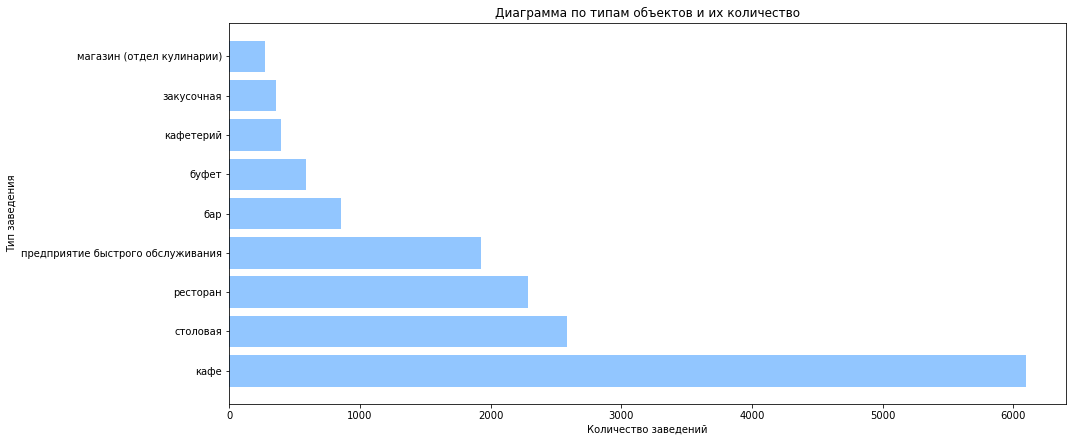

In [26]:
plt.figure(figsize=(15,7))                                     # Размер диаграммы
plt.style.use('seaborn-pastel')                                # Стиль фона
plt.xlabel('Количество заведений')                             # Подпись по оси Х
plt.ylabel('Тип заведения')                                    # Подпись по оси Y
plt.title('Диаграмма по типам объектов и их количество')       # Название диаграммы
plt.barh(type_grouped['object_type'],type_grouped['id'])       # Горизонтальная столбчатая диаграмма
plt.show()                                                     # Просмотр количества заведения

Теперь определим процент по типам заведений от общего числа.

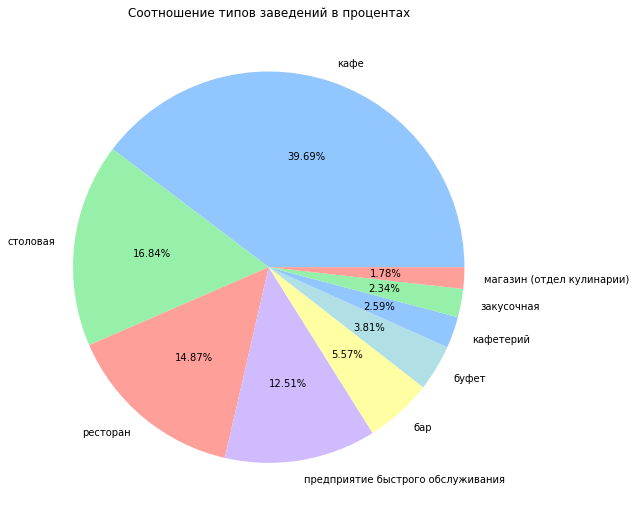

In [27]:
plt.figure(figsize=(9,9))                               # Размер круговой диаграммы
values = type_grouped['id']                             # Количество объектов каждого типа
labels = type_grouped['object_type']                    # Название типа по каждому сектору
plt.pie(values,labels = labels,autopct='%.2f%%')        # Построение круговой диаграммы
plt.title('Соотношение типов заведений в процентах')    # Название круговой диаграммы
plt.show()                                              # Отображение диаграммы

Таким образом, на графиках можно увидеть как количество заведений, так и процентное соотношение от общего числа.

### Задание 2

<i>Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график. 

Сгруппируем заведения по признаку сетевого заведения в новый датафрейм.

In [28]:
chain_grouped = rest_df.groupby('chain').agg(          # Групировка по признаку включения в сеть
    {'id':'nunique'}).reset_index()                    # с количеством заведений
display(chain_grouped)                                 # Просмотр таблицы

,chain,id
0,да,2968
1,нет,12398


Дополним картину круговой диаграммой с отображением процентного соотношения.

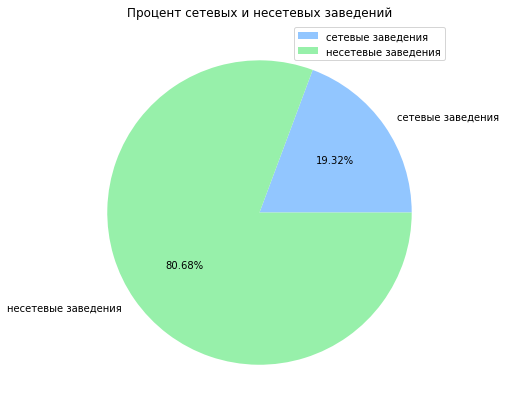

In [29]:
plt.figure(figsize=(7,7))                                        # Размер диаграммы
values1 = chain_grouped['id']                                    # Количество заведений каждого типа
chain_labels = ['сетевые заведения','несетевые заведения']       # Добавление названий секторов к описанию
plt.pie(values1,labels=chain_labels,autopct='%.2f%%')            # Построение круговой диагаммы
plt.title('Процент сетевых и несетевых заведений')               # Название диаграммы
plt.legend()                                                     # Отображение легенды
plt.show()                                                       # Просмотр диаграммы

Согласно данным, менее 20 процентов заведений входят в какую-либо из сетей.

### Задание 3

<i>Для какого вида объекта общественного питания характерно сетевое распространение?   

Чтобы ответить на этот вопрос, сначала определим среди сетевых объектов количество заведений разного типа.

In [30]:
chained_grouped = rest_df[rest_df['chain']=='да'].groupby(           # Группировка по типу сетевых заведений
    'object_type',as_index=False).agg(                               # с указанием количества
    {'id':'nunique'}).sort_values(by='id',ascending=False)           # и сортировкой по убыванию
display(chained_grouped)                                             # Просмотр таблицы

,object_type,id
3,кафе,1396
6,предприятие быстрого обслуживания,791
7,ресторан,544
5,магазин (отдел кулинарии),78
2,закусочная,56
4,кафетерий,52
0,бар,37
1,буфет,11
8,столовая,3


Больше всего сетевых заведений имеют тип объекта `кафе`,`предприятие быстрого обслуживания` и `ресторан`. Построим на основе этих данных график.

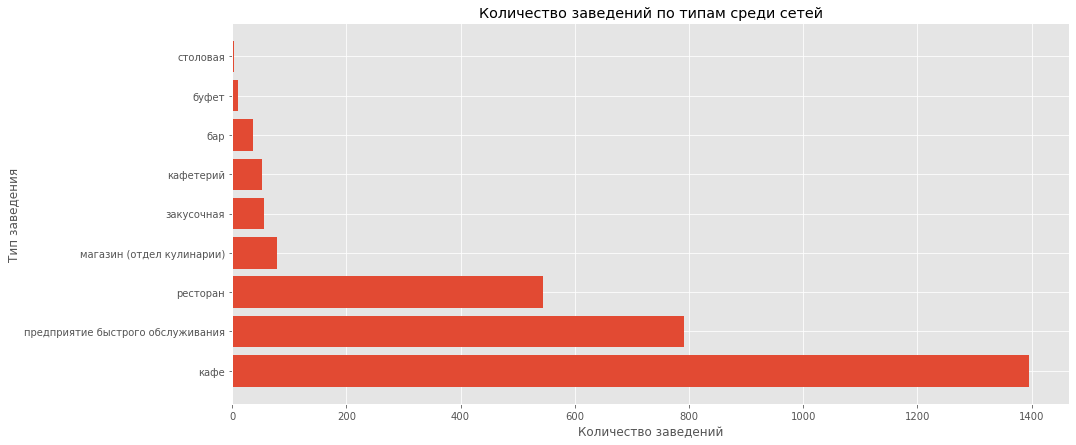

In [31]:
plt.figure(figsize=(15,7))                                        # Размер графика
plt.style.use('ggplot')                                           # Стиль фона
plt.title('Количество заведений по типам среди сетей')            # Название графика
plt.xlabel('Количество заведений')                                # Подпись по оси Х
plt.ylabel('Тип заведения')                                       # Подпись по оси Y
plt.barh(chained_grouped['object_type'],chained_grouped['id'])    # Горизонтальная столбчатая диаграмма
plt.show()                                                        # Просмотр количества заведения

Поскольку мы изучаем сетевые заведения, у заведений, находящихся в одной сети будут одинаковые названия. Определим количество сетей на наиболее распространенным типам и среднее количество заведений в сети.

In [32]:
chained_div = rest_df[rest_df['chain']=='да'].groupby(
    'object_type').agg({
    'id':'nunique','object_name':'nunique'}).reset_index()              # Группировка по типам заведения
pop_type = ['ресторан','предприятие быстрого обслуживания','кафе']      # Список самых часто встречающихся типов объектов
sel_div = chained_div.query('object_type in @pop_type')                 # Запрос по списку
sel_div['average'] = (
    sel_div['id'] / sel_div['object_name']).astype(int)                 # Расчет среднего числа заведений в сети
display(sel_div)                                                        # Просмотр результата

,object_type,id,object_name,average
3,кафе,1396,428,3
6,предприятие быстрого обслуживания,791,158,5
7,ресторан,544,247,2


Согласно расчетам, сетевое распространение среди самых распространенных типов заведений более характерно для предприятий быстрого питания: в среднем в каждой сети такого типа насчитывается 5 объектов.

### Задание 4

<i>Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Чтобы охарактеризовать распределение количества мест в заведениях среди сетевых заведений, сформируем диаграмму рассеяния по результатy запроса с соответствующим признаком. Сначала сформируем датафрейм с данными по сетевым заведениям. 

In [33]:
chained_df = rest_df.query(
    'chain == "да"').reset_index(drop=True)                  # Запрос по сетевых заведениям со сбросом индекса
display(len(chained_df))                                     # Просмотр количества строк

2968

Всего среди сетевых заведений нашлось 2968 объектов. Сформируем статистическое описание по столбцу с количеством мест по запросу.

In [34]:
chained_df['number'].describe()                 # Статистическое описание по количеству мест

count    2968.000000
mean       52.919811
std        57.140644
min         0.000000
25%        15.000000
50%        40.000000
75%        72.000000
max       580.000000
Name: number, dtype: float64

Поскольку по описанию минимальным значением количества мест является 0, узнаем количество объектов, где нет мест для посетителей, разделим их по типам и узнаем сколько сетей имеют такие объекты.

In [35]:
zero_num = chained_df.query(                                    # Запрос по сетевым заведениям,
    'number == 0').reset_index(                                 # гдк количество мест для посетителей равно 0
    drop=True).groupby('object_type',                           # Группировка по типам объекта
                       as_index=False).agg({                    # с переназначением индекса
    'id':'count','object_name':'nunique'                        # Добавление количества объектов и количества сетей
}).rename(columns={'object_type':'Тип объекта',                 
                   'id':'Кол-во заведений',
                   'object_name':'Кол-во сетей'})               # Переименование столбцов
display(zero_num)                                               # Просмотр результата

,Тип объекта,Кол-во заведений,Кол-во сетей
0,бар,1,1
1,буфет,8,5
2,закусочная,18,14
3,кафе,55,32
4,кафетерий,15,5
5,магазин (отдел кулинарии),33,9
6,предприятие быстрого обслуживания,120,41
7,ресторан,18,9


Таким образом, мы получили количество заведений, где персонал работает только на вынос. Теперь выполним запрос по объектам, где количество мест больше нуля и посмотрим статистическое описание. 

In [36]:
chained_df.query('number > 0')['number'].describe()     # Статистическое описание по количеству мест

count    2700.000000
mean       58.172593
std        57.302521
min         1.000000
25%        20.000000
50%        43.000000
75%        80.000000
max       580.000000
Name: number, dtype: float64

После исключения осталось всего 2700 заведений, где по основной статистике три четверти объектов имеют до 80 сидячих мест в помещении. Сформируем статистику по количеству мест, где установим в качестве порога общее среднее значение количества мест, равное 58.

In [37]:
std_seats = int(np.mean(chained_df.query('number > 0')['number']))         # Выделение общего среднего количества мест
sp_df = chained_df.query('number > 0')                                     # Запрос по сетевым заведениям с местами
std_type_stat = []                                                         # Список для статистики
for obn in sp_df['object_type'].unique():                                  # Цикл по типам объектов
    obn_df = sp_df.query('object_type == @obn')                            # Запрос по типу объекта
    stat=[obn, len(obn_df),                                                # Запись типа, длины запроса, 
          len(obn_df.query('number < @std_seats')),            # количества объектов с вместимостью меньше среднего,
          len(obn_df.query('number > @std_seats'))]            # и количества объектов с вместимостью больше среднего
    std_type_stat.append(stat)                                 # Добавление списка с данными в список для сбора 
obj_places = pd.DataFrame(data=std_type_stat,
                          columns=['Тип объекта','Общее количество',
                                   'Меньше среднего','Больше среднего'])   # Формирование датафрейма
display(obj_places)                                                        # Просмотр датафрейма

,Тип объекта,Общее количество,Меньше среднего,Больше среднего
0,кафе,1341,952,385
1,предприятие быстрого обслуживания,671,486,182
2,ресторан,526,153,373
3,магазин (отдел кулинарии),45,45,0
4,кафетерий,37,35,2
5,закусочная,38,36,2
6,бар,36,23,13
7,столовая,3,1,2
8,буфет,3,2,1


Сформируем таблицу по разным сетям со средним количеством мест в них и определим общее среднее занчение количества мест.

In [38]:
nets_stat = chained_df.query('number > 0').groupby(
    'object_name',as_index=False).agg({'number':'mean'})      # Группировка по разным сетям и среднее количество мест в них
int(nets_stat['number'].mean())                               # Среднее значение количества мест по сетям

63

По данным из таблицы выходит, что по сетевым ресторанам и столовым вместимость чаще получается больше общей средней, а среди отделов кулинарии нет ни одного магазина с количеством мест больше общего среднего. Для полноты картины соберем общую статистику по разным типам.

In [39]:
type_ind_stat = []                                           # Список для сбора статистики
ti_names = ['object_type','count','mean','std',
            'min','20%','50%','75%','max']                   # Наименования столбцов
for to in sp_df['object_type'].unique():                           # Цикл по типам
    to_list = [to]                                                 # Список для статистики с названием типа объекта
    temp_df = sp_df.query('object_type == @to')                    # Запрос по типу объекта
    to_list+=list(temp_df['number'].describe().astype(int))        # Добавление к списку данных из описания с округлением
    type_ind_stat.append(to_list)                            # Добавление списка с данными в список для статистики
places_stat = pd.DataFrame(data=type_ind_stat,
                           columns=ti_names)                 # Формирование таблицы
display(places_stat)                                         # Просмотр таблицы   

,object_type,count,mean,std,min,20%,50%,75%,max
0,кафе,1341,49,44,2,20,40,63,456
1,предприятие быстрого обслуживания,671,47,51,1,15,35,60,580
2,ресторан,526,103,73,4,50,90,140,500
3,магазин (отдел кулинарии),45,15,13,1,5,10,20,48
4,кафетерий,37,17,17,1,8,10,20,85
5,закусочная,38,21,18,2,8,18,33,91
6,бар,36,54,40,3,26,45,82,150
7,столовая,3,112,53,55,87,120,141,162
8,буфет,3,46,25,20,35,50,60,70


Из-за разницы между размерами выборок и количеством мест в них выделим медиану по 20 процентам значений для разных типов заведений.

In [40]:
display(places_stat['20%'].median())                    # Медиана по пятой части помещений

20.0

Затем определим медиану по разным типам объектов для 75% значений.

In [41]:
display(places_stat['75%'].median())                    # Медиана по трем четвертям помещений

60.0

Посмотрим на столбчатую диаграмму на основе значений в столбце `75%` с установленной по медиане визуальной границей.

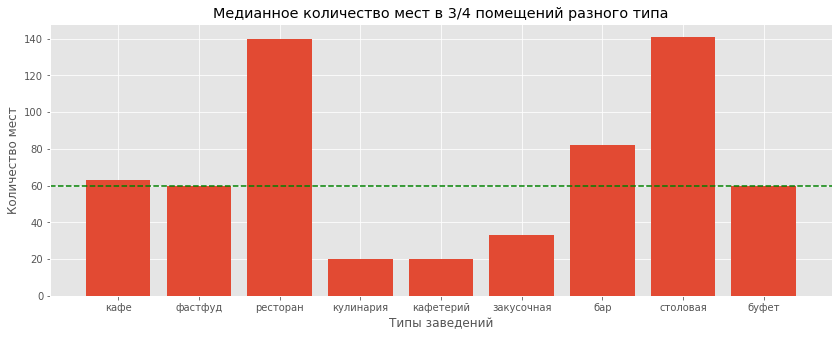

In [42]:
places_stat['object_type'][1] = 'фастфуд'                               # Переименование длинных наименований
places_stat['object_type'][3] = 'кулинария'
plt.figure(figsize=(14,5))                                                   # Размер диаграммы
plt.bar(places_stat['object_type'],places_stat['75%'])                       # Построение столбчатой диаграмы
plt.axhline(y=places_stat['75%'].median(),linestyle='--',color='green')      # Горизонтальная линия диаграммы
plt.title('Медианное количество мест в 3/4 помещений разного типа')          # Название диаграммы
plt.xlabel('Типы заведений')                                                 # Подпись по оси X
plt.ylabel('Количество мест')                                                # Подпись по оси Y
plt.show()                                                                   # Просмотр диаграммы

Поскольку для большинства объектов медиана очень близка к среднему значению количества мест в сетях и общему среднему числу мест в заведении выберем медиану как оптимальное количество мест в планируемом заведении. Осталось построить диаграмму рассеяния по различным сетям с указанием количества мест и заведений в ней, для чего сформируем специальный датафрейм с указанием типа заведений в сети.

In [43]:
type_ncap = chained_df.groupby(
    ['object_name','object_type'],as_index=False).agg(    # Группировка по названию и типу сети
    {'id':'count','number':'sum'}).sort_values(           # с количеством заведений в ней и суммой мест
    by='number').reset_index(drop=True)                   # и сортировкой по сумме мест по возрастанию
type_ncap.tail()                                          # Просмотр последних 5 строк

,object_name,object_type,id,number
962,Бургер Кинг,предприятие быстрого обслуживания,83,3851
963,Чайхона №1,ресторан,36,5850
964,KFC,предприятие быстрого обслуживания,99,5926
965,Макдоналдс,предприятие быстрого обслуживания,80,6948
966,Шоколадница,кафе,134,7390


Последние 5 строк указывают на самые большие сети среди всех как по сумме мест, так и по количеству объектов. Построим диаграмму рассеяния по полученным данным.

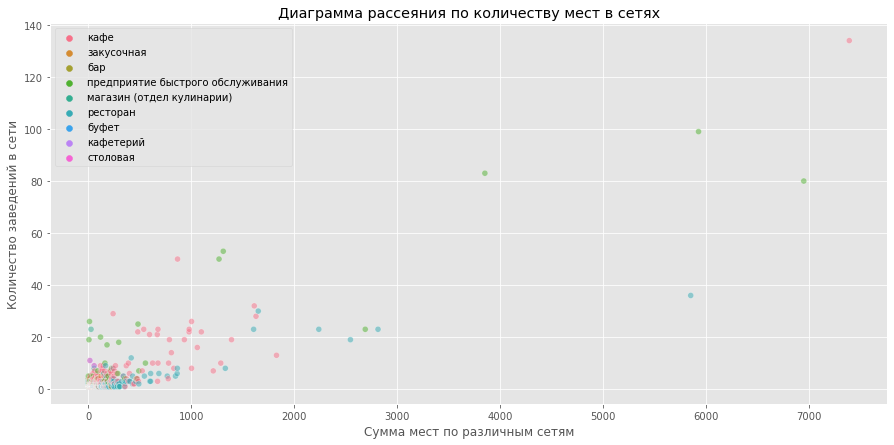

In [44]:
plt.figure(figsize=(15,7))                                        # Размер диаграммы
sns.scatterplot(type_ncap['number'],type_ncap['id'],
                hue=type_ncap['object_type'],alpha=0.5)           # Диаграмма по количеству объектов в сети и сумме мест
plt.title('Диаграмма рассеяния по количеству мест в сетях')       # Название диаграммы
plt.xlabel('Сумма мест по различным сетям')                       # Подпись по оси X
plt.ylabel('Количество заведений в сети')                         # Подпись по оси Y
plt.legend()                                                      # Отображение легенды
plt.show()                                                        # Просмотр диаграммы

После этого рассчитаем среднее количество мест в сетях и по этим данным построим новую диаграмму рассеяния. 

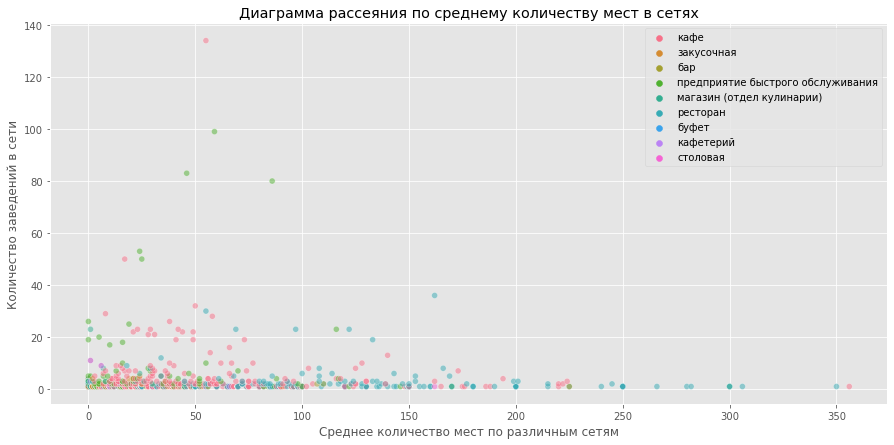

In [45]:
type_ncap['mean'] = (type_ncap['number'] / type_ncap['id']).astype(int)    # Столбец со средним количеством мест
plt.figure(figsize=(15,7))                                                 # Размер диаграммы
sns.scatterplot(type_ncap['mean'],type_ncap['id'],                         # Диаграмма по количеству объектов
                hue=type_ncap['object_type'],alpha=0.5)                    # в сети и сумме мест
plt.title('Диаграмма рассеяния по среднему количеству мест в сетях')       # Название диаграммы
plt.xlabel('Среднее количество мест по различным сетям')                   # Подпись по оси X
plt.ylabel('Количество заведений в сети')                                  # Подпись по оси Y
plt.legend()                                                               # Отображение легенды
plt.show()                                                                 # Просмотр диаграммы

Получается, что большинство сетей имеют малое количество объектов и малое количество мест в них. Дополним картину просмотром статистики по значениям общего количества мест в сети.

In [46]:
type_ncap['number'].describe()                   # Статистическое описание по сумме мест в разных сетях

count     967.000000
mean      162.426060
std       504.130811
min         0.000000
25%        23.000000
50%        60.000000
75%       125.000000
max      7390.000000
Name: number, dtype: float64

И заодно посмотрим общую статистику по количеству объектов в различных сетях.

In [47]:
type_ncap['id'].describe()                       # Статистическое описание по количеству объектов в разных сетях

count    967.000000
mean       3.069286
std        8.045057
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      134.000000
Name: id, dtype: float64

Так и есть: в большинстве сетей обычно до 2 объектов и до 125 мест для посетителей. 

### Задание 5

<i>Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

Для получения статистики по типам заведений выделим вместимость по каждому объекту и распределим в разные списки.

In [48]:
num_df = []                                                  # Пустой список со списками
for obj_type in rest_types:                                  # Цикл по типам заведения
    num_list = []                                            # Пустой список для сбора значений
    for i in range(len(chained_df)):                         # Внутренний цикл по строкам
        if chained_df['object_type'][i] == obj_type:         # Если в строке типы заведения совпадают,
            num_list.append(chained_df['number'][i])         # то добавим количество мест в заведении в список для сбора 
    num_df.append(num_list)                                  # По окончанию списка добавить его в первый список
display(len(num_df))                                         # Просмотр количества списков

9

У нас получился список списков, который неудобно читать и анализировать. Для удобства расчета статистики по количеству мест для каждого типа заведения создадим специальную функцию `capacity_stat`, в которой будут указаны тип заведения, количество, сумма мест по типу, а также минимальное, максимальное и среднее значения количества мест по типу. 

In [49]:
def capacity_stat(names,lists):                                    # Объявление функции
    full_stat = []                                                 # Пустой список для списков с данными
    cols = ['name','count','total','min','max','average']          # Список с названиями столбцов
    for j in range(len(lists)):                                    # Цикл по указанным спискам
        stat_list = [names[j]]                                     # Добавление названия
        stat_list.append(len(lists[j]))                            # Добавление количества значений
        stat_list.append(sum(lists[j]))                            # Добавление суммы значений
        stat_list.append(min(lists[j]))                            # Добавление минимального значения
        stat_list.append(max(lists[j]))                            # Добавление максимального значения
        stat_list.append(int(np.mean(lists[j])))                   # Добавление среднего значения
        full_stat.append(stat_list)                                # Добавление готового списка в основной список
    stat_df = pd.DataFrame(data=full_stat,columns=cols)            # Преобразование списка списков в датафрейм
    return stat_df                                                 # Возвращение датафрейма

А также функцию `capacity_stat_v2` с дополнительными столбцами, где будет отображаться количество объектов с количеством мест меньше и больше среднего количества.

In [50]:
def capacity_stat_v2(df):                                          # Объявление функции
    obj_types = df['object_type'].unique()                         # Наименование столбцов
    stat_names = ['object_type','total','min','max','average',
                  'median','less_avg','more_avg']
    stat_list = []                                                 # Пустой список для сбора данных
    for ot in obj_types:                                           # Цикл по типам объектов
        ot_df = chained_df.query('object_type == @ot')             # Запрос по исходному датафрейму с указанием типа
        ot_list = [ot, len(ot_df), min(ot_df['number']),
                   max(ot_df['number']),
                   int(np.mean(ot_df['number'])),
                   int(np.median(ot_df['number']))]                # Список со стандартными значениями
        less_df = ot_df.query('number < @ot_list[4]')              # Запрос по числу мест в заведении меньше среднего
        ot_list.append(len(less_df))                               # Добавление числа таких мест в список
        more_df = ot_df.query('number > @ot_list[4]')              # Запрос по числу мест в заведении больше среднего
        ot_list.append(len(more_df))                               # Добавление числа мест
        stat_list.append(ot_list)                                  # Добавление списка после выполнения расчетов
    sp_stat = pd.DataFrame(data=stat_list,columns=stat_names)      # Формирование датафрейма
    return sp_stat                                                 # Возвращение датафрейма

Вызовем эту функцию, чтобы посмотреть распределение числа объектов относительно среднего значения.

In [51]:
test_sp = capacity_stat_v2(chained_df)                             # Вызов функции
display(test_sp)                                                   # Просмотр датафрейма со статистикой

,object_type,total,min,max,average,median,less_avg,more_avg
0,кафе,1396,0,456,47,40,842,552
1,предприятие быстрого обслуживания,791,0,580,40,25,477,273
2,ресторан,544,0,500,100,88,344,181
3,магазин (отдел кулинарии),78,0,48,8,3,49,27
4,кафетерий,52,0,85,12,8,37,15
5,закусочная,56,0,91,14,8,34,22
6,бар,37,0,150,53,45,23,13
7,буфет,11,0,70,12,0,8,3
8,столовая,3,55,162,112,120,1,2


Вызовем функцию и сформируем из данных датафрейм со статистикой вместимости.

In [52]:
cap_df = capacity_stat(rest_types,num_df)                   # Формирование датафрейма со статистикой
display(cap_df)                                             # Просмотр датафрейма

,name,count,total,min,max,average
0,кафе,1396,66208,0,456,47
1,столовая,3,337,55,162,112
2,закусочная,56,805,0,91,14
3,предприятие быстрого обслуживания,791,31772,0,580,40
4,ресторан,544,54527,0,500,100
5,кафетерий,52,638,0,85,12
6,буфет,11,140,0,70,12
7,бар,37,1962,0,150,53
8,магазин (отдел кулинарии),78,677,0,48,8


Установим краткие наименования типов объектов в датафрейме со статистикой.

In [53]:
cap_df['name'][3] = 'предприятие БО'                      # Переименование типа объекта в строке 3
cap_df['name'][8] = 'отдел кулинарии'                     # Переименование типа объекта в строке 8
display(cap_df)                                           # Просмотр после изменений

,name,count,total,min,max,average
0,кафе,1396,66208,0,456,47
1,столовая,3,337,55,162,112
2,закусочная,56,805,0,91,14
3,предприятие БО,791,31772,0,580,40
4,ресторан,544,54527,0,500,100
5,кафетерий,52,638,0,85,12
6,буфет,11,140,0,70,12
7,бар,37,1962,0,150,53
8,отдел кулинарии,78,677,0,48,8


Выделим срез данных (тип заведения и среднее количество мест) для построения столбчатой диаграммы и отсортируем его.

In [54]:
cap_sorted = cap_df[['name','average']].sort_values(
                    by='average',ascending=False)           # Срез и сортировка по значению среднего числа
display(cap_sorted)                                         # Просмотр после выполнения

,name,average
1,столовая,112
4,ресторан,100
7,бар,53
0,кафе,47
3,предприятие БО,40
2,закусочная,14
5,кафетерий,12
6,буфет,12
8,отдел кулинарии,8


На основе сортированного среза данных с типами заведений и среднего числа мест построим столбчатой диаграммы.

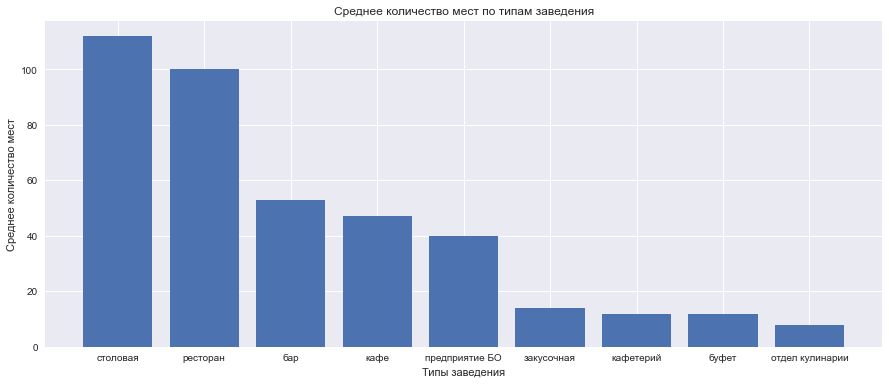

In [55]:
plt.figure(figsize=(15,6))                                  # Размер диаграммы
plt.style.use('seaborn')                                    # Стиль диаграммы
plt.bar(cap_sorted['name'],cap_sorted['average'])           # Исходные данные для построения
plt.title('Среднее количество мест по типам заведения')     # Название диаграммы
plt.xlabel('Типы заведения')                                # Подпись по оси X
plt.ylabel('Среднее количество мест')                       # Подпись по оси Y
plt.show()                                                  # Просмотр диаграммы

По этой статистике выходит, что для разных типов заведения характерно разное количество мест. Если для отделов кулинарии, закусочных, кафетериев и буфетов в среднем меньше 20 мест, то для столовых, ресторанов, баров, предприятий быстрого обслуживания и кафе приходится на объект в среднем от 40 мест и более. Больше всего мест в среднем приходится на столовые.

### Задание 6

<i>Выделите в отдельный столбец информацию об улице из столбца address.

Сначала выделим количество уникальных адресов объектов по целому датафрейму.

In [56]:
places = list(rest_df['address'].unique())                  # Выделение уникальных адресов
display(len(places))                                        # Просмотр числа уникальных адресов

9108

Всего обнаружено 9108 уникальных адресов, это значит, что часть заведений может находиться в одном и том же здании.

Чтобы определить безошибочно все типы улиц, площадей, переулков и прочих разнообразных видов образований, был придуман алгоритм, который позволит выделить разнообразные названия улиц по списку уникальных адресов, не пропуская ни одного уникального типа улицы, чтобы потом произвести корректную фильтрацию с выбором улицы для создания дополнительного столбца. Суть алгоритма: чтобы не разглядывать обозначения улиц, изначально выделил улицы, бульвары, проспекты и иные типы, отмечая количество таковых с отображением списка незатронутых адресов, а затем добавляя к условиям совпадения типа улицы новые обнаруженные пункты, выполняя добавление новых типов улиц в фильтрацию до тех пор, пока список незатронутых адресов не опустеет.

In [57]:
count = 0                                  # Счетчик затронутых адресов
lost = []                                  # Список для пропущенных адресов
for i in range(len(places)):               # Цикл по списку уникальных адресов
    if 'улица' in places[i]:               # Условие 1
        count+=1                           # Увеличение счетчика
    elif 'бульвар' in places[i]:           # Условие 2
        count+=1                           # Увеличение счетчика
    elif 'проспект' in places[i]:          # Условие 3
        count+=1                           # Увеличение счетчика
    elif 'переулок' in places[i]:          # Условие 4
        count+=1                           # Увеличение счетчика
    elif 'проезд' in places[i]:            # Условие 5
        count+=1                           # Увеличение счетчика
    elif 'шоссе' in places[i]:             # Условие 6
        count+=1                           # Увеличение счетчика
    elif 'площадь' in places[i]:           # Условие 7
        count+=1                           # Увеличение счетчика
    elif 'набережная' in places[i]:        # Условие 8
        count+=1                           # Увеличение счетчика
    elif 'Автодор' in places[i]:           # Условие 9
        count+=1                           # Увеличение счетчика
    elif 'аллея' in places[i]:             # Условие 10
        count+=1                           # Увеличение счетчика
    elif 'поселение' in places[i]:         # Условие 11
        count+=1                           # Увеличение счетчика
    elif 'Зеленоград' in places[i]:        # Условие 12
        count+=1                           # Увеличение счетчика
    elif 'квартал' in places[i]:           # Условие 13
        count+=1                           # Увеличение счетчика
    elif 'линия' in places[i]:             # Условие 14
        count+=1                           # Увеличение счетчика
    elif 'микрорайон' in places[i]:        # Условие 15
        count+=1                           # Увеличение счетчика
    elif 'тупик' in places[i]:             # Условие 16
        count+=1                           # Увеличение счетчика
    elif 'посёлок' in places[i]:           # Условие 17
        count+=1                           # Увеличение счетчика
    elif 'просек' in places[i]:            # Условие 18
        count+=1                           # Увеличение счетчика
    elif 'территория' in places[i]:        # Условие 19
        count+=1                           # Увеличение счетчика
    else: lost.append(places[i])           # При несовпадении с условиями добавить в список с пропущенными адресами
display(lost)                              # После выполнения полной фильтрации список должен быть пустым
print('Обработано адресов:',count)         # Печать сообщения

[]

Обработано адресов: 9108


Согласно сайту Зеленограда (https://www.zelenograd.ru/gid/kak-ustroen-zelenograd/), город образует отдельный административный округ, имеет нестандартную архитектуру и в нем могут не попадаться улицы в классическом понимании, поэтому он будет включен в фильтрацию целиком. Далее создадим список типов "улиц" без Зеленограда, который используем для поиска и сравнения со строкой, в которой содержится адрес.

In [58]:
strt_types = ['Автодор','улица','бульвар','проспект','переулок',
              'шоссе','площадь','набережная','проезд','аллея',
              'поселение','квартал','линия','микрорайон','тупик',
              'посёлок','просек','территория']                        # Список типов улиц (без Зеленограда)
display(len(strt_types))                                              # Печать длины списка

18

Затем, используя этот список, создадим функцию `address_street` для выделения улицы из адреса.

In [59]:
def address_street(adrs):                                     # Объявление функции
    text_block = adrs.split(', ')                             # Разделение строки с адресом на блоки
    for i in range(len(text_block)):                          # Цикл по блокам
        if 'Зеленоград' in text_block[i]:                     # Если есть в адресе Зеленоград, то
            street = text_block[i] + ', '+ text_block[i+1]    # прибавим блок с названием города и домом из адреса
        for kind in strt_types:                               # Цикл по типам улиц
            if kind in text_block[i]:                         # Если тип улицы содержится в блоке, то
                street = text_block[i]                        # запишем его в переменную улицы
    return street                                             # Возвращение улицы из адреса

Теперь применим эту функцию для создания нового столбца `street`.

In [60]:
rest_df['street'] = rest_df['address'].apply(lambda x: address_street(x))    # Применение функции
rest_df.dtypes                                                               # Просмотр типов данных

id              int64
object_name    object
chain          object
object_type    object
address        object
number          int64
street         object
dtype: object

Посмотрим последние 10 строк после добавления нового столбца.

In [61]:
rest_df.tail(10)                         # Последние 10 строк датафрейма

,id,object_name,chain,object_type,address,number,street
15356,220618,Шоколадница,да,кафе,"город Москва, Митинская улица, дом 36, корпус 1",100,Митинская улица
15357,218692,Шоколадница,да,кафе,"город Москва, площадь Джавахарлала Неру, дом 1",30,площадь Джавахарлала Неру
15358,213724,Шоколадница,да,кафе,"город Москва, Варшавское шоссе, дом 87Б",54,Варшавское шоссе
15359,222077,Кофейня «Шоколадница»,да,кафе,"город Москва, Кантемировская улица, дом 47",72,Кантемировская улица
15360,219759,Шоколадница,да,кафе,"город Москва, улица Вавилова, дом 3",36,улица Вавилова
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,Киевское шоссе
15365,222535,Шоколадница,да,кафе,"город Москва, Ходынский бульвар, дом 4",10,Ходынский бульвар


Новый столбец с улицами сформирован.

### Задание 7

<i>Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Создадим через группировку по улицам таблицу с количеством заведенией на ней.

In [62]:
st_grouped = rest_df.groupby('street',as_index=False).agg(       # Группировка по улице с указанием количества объектов
    {'id':'count'}).sort_values(by='id',ascending=False)         # и сортировкой по убыванию
st_grouped.head()                                                # Просмотр первых 5 строк

,street,id
1590,проспект Мира,204
1038,Профсоюзная улица,183
711,Ленинградский проспект,173
1022,Пресненская набережная,167
424,Варшавское шоссе,165


Выделим топ-10 улиц по количеству объектов.

In [63]:
top_st = st_grouped[:10].reset_index(drop=True)         # Срез по первым 10 названием улиц   
display(top_st)                                         # Просмотр среза 

,street,id
0,проспект Мира,204
1,Профсоюзная улица,183
2,Ленинградский проспект,173
3,Пресненская набережная,167
4,Варшавское шоссе,165
5,Ленинский проспект,148
6,проспект Вернадского,132
7,Кутузовский проспект,114
8,Каширское шоссе,112
9,Кировоградская улица,110


Отобразим эти данные визуально с помощью горизонтальной столбчатой гистограммы.

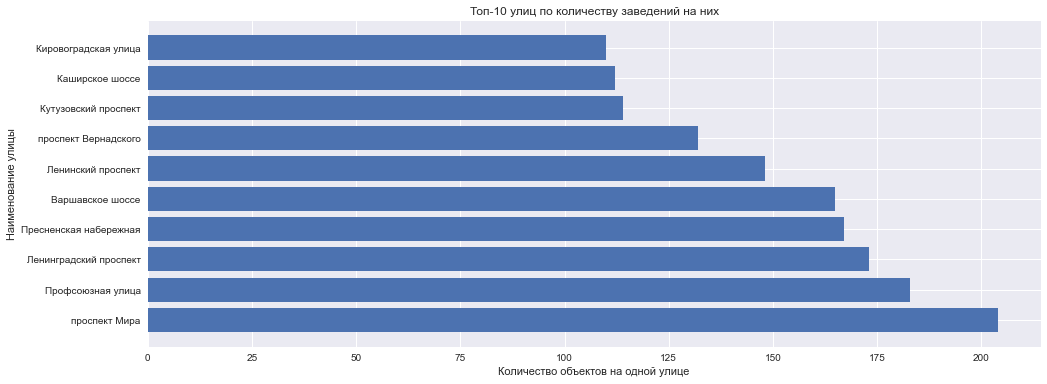

In [64]:
plt.figure(figsize=(16,6))                                   # Размер столбчатой диаграммы
plt.barh(top_st['street'],top_st['id'])                      # Построение гистограммы
plt.title('Топ-10 улиц по количеству заведений на них')      # Название гистограммы
plt.xlabel('Количество объектов на одной улице')             # Подпись по оси X
plt.ylabel('Наименование улицы')                             # Подпись по оси Y
plt.show()                                                   # Просмотр диаграммы

Для того, чтобы определять районы по указанной улице нам понадобится еще одна функция - `define_district`, которая будет проводить сравнения по созданному справочнику.

In [65]:
def define_district(street_name):                             # Объявление функции
    selected = streets.query(
        '@street_name in street').reset_index()               # Запрос по названию улицы
    if len(selected) == 0:                                    # Если улица не будет найдена,
            dstr = 'Не в Москве!'                             # в спискок районов запишем, что улица не в Москве
    else: dstr = selected['districts'][0]                     # или запишем список районов
    return dstr                                               # Возвращение списка районов

Применим функцию к топ-10 популярным улицам.

In [66]:
top_st['districts'] = top_st['street'].apply(lambda x: define_district(x))    # Применение функции для определения районов
display(top_st)                                                               # Просмотр датафрейма

,street,id,districts
0,проспект Мира,204,Мещанский район; Алексеевский район; район Мар...
1,Профсоюзная улица,183,Академический район; район Коньково; Обручевск...
2,Ленинградский проспект,173,район Аэропорт; район Беговой; район Сокол; Хо...
3,Пресненская набережная,167,Пресненский район
4,Варшавское шоссе,165,Донской район; район Нагатино-Садовники; Нагор...
5,Ленинский проспект,148,район Якиманка; Донской район; Гагаринский рай...
6,проспект Вернадского,132,Гагаринский район; Ломоносовский район; район ...
7,Кутузовский проспект,114,район Дорогомилово; район Фили-Давыдково
8,Каширское шоссе,112,район Москворечье-Сабурово; район Нагатино-Сад...
9,Кировоградская улица,110,район Чертаново Северное; район Чертаново Цент...


Как и было сказано ранее, Зеленоград входит в отдельный административный округ, поэтому специально для него создадим функцию для заполнения района, для чего найдем и выделим название округа из списка округов. 

In [67]:
zgrad_area = ''                               # Пустая строка для названия округа
for area in areas:                            # Цикл по названиям округов
    if 'Зеленоград' in area:                  # Если в названии есть Зеленоград, то
        zgrad_area = area                     # записать название округа
display(zgrad_area)                           # Просмотр значения

'Зеленоградский административный округ'

Название округа выделено, создадим для заполнения столбца с районами функцию `zgrad_district`, если нам понадобится добавить округ в датафрейм.

In [68]:
def zgrad_district(df):                                 # Объявление функции
    for k in range(len(df)):                            # Цикл по строкам
        text_block = df['street'][k].split(', ')        # Разделение строки адреса на блоки
        for text in text_block:                         # Цикл по блокам
            if 'Зеленоград' in text:                    # Если блок содержит название Зеленоград, то 
                df['districts'][k] = zgrad_area         # запишем название округа
    return df                                           # Возвращение датафрейма

Теперь определим список затронутых районов города. Для этого создадим функцию под названием `list_of_districts`, которая выделит из датафрейма упомянутые в нем районы Москвы. 

In [69]:
def list_of_districts(df):                                # Объявление функции
    dst_unique = []                                       # Общий список с уникальными районами 
    for i in range(len(df)):                              # Цикл по длине датафрейма
        dst_list = df['districts'][i].split('; ')         # Разделенный список с районами 
        for dst in dst_list:                              # Цикл для записи уникальных значений
            if dst not in dst_unique:                     # Если нет в списке уникальных значений, то
                dst_unique.append(dst)                    # добавим в список уникальных районов
    return dst_unique                                     # Возвращение списка уникальных районов

Применим эту функцию к топ-10 и посмотрим количество районов.

In [70]:
top_dst = list_of_districts(top_st)                    # Применение функции для определения районов 
display(len(top_dst))                                  # Просмотр длины списка районов

38

Получается, что улиц всего 10, но они проходят аж через 38 районов города. Посмотрим какие именно это районы.

In [71]:
display(top_dst)                 # Просмотр списка районов

['Мещанский район',
 'Алексеевский район',
 'район Марьина Роща',
 'Останкинский район',
 'район Ростокино',
 'район Свиблово',
 'Ярославский район',
 'Академический район',
 'район Коньково',
 'Обручевский район',
 'район Тёплый Стан',
 'район Черёмушки',
 'район Ясенево',
 'район Аэропорт',
 'район Беговой',
 'район Сокол',
 'Хорошёвский район',
 'Пресненский район',
 'Донской район',
 'район Нагатино-Садовники',
 'Нагорный район',
 'район Чертаново Северное',
 'район Чертаново Центральное',
 'район Чертаново Южное',
 'район Северное Бутово',
 'район Южное Бутово',
 'поселение Щербинка',
 'район Якиманка',
 'Гагаринский район',
 'Ломоносовский район',
 'район Проспект Вернадского',
 'район Тропарёво-Никулино',
 'район Раменки',
 'район Дорогомилово',
 'район Фили-Давыдково',
 'район Москворечье-Сабурово',
 'район Орехово-Борисово Северное',
 'район Орехово-Борисово Южное']

Таким образом, в результате анализа данных по самой большой плотности расположения объектов на одной улице были определены 38 районов с максимальной плотностью расположения заведений.

Предположим, что наибольшее количество заведений будет приходится на публичные места с высокой посещаемостью, например торговые центры. Выделим несколько адресов с наибольшим количеством объектов по ним.

In [72]:
tst = list(top_st['street'])                          # Список в выделенными улицами
top_places = (rest_df.query(                          # Подзапрос по объектам,
    'street in @tst').groupby(                        # которые расположены на улицах из топ-списка 
    'address',as_index=False).agg(                    # с группировкой по адресу и определением количества заведений
    {'id':'count'}).sort_values(                      # и сортировкой по убыванию количества
    by='id',ascending=False)).query('id >= 10')                                   # в запросе с количеством мест больше 10
print('Обнаружено адресов с большой плотностью концентрации:',len(top_places))    # Печать сообщения
top_places.head()                                                                 # Первые 5 строк таблицы 

Обнаружено адресов с большой плотностью концентрации: 29


,address,id
377,"город Москва, Пресненская набережная, дом 2",63
542,"город Москва, проспект Мира, дом 211, корпус 2",60
153,"город Москва, Кировоградская улица, дом 13А",53
201,"город Москва, Кутузовский проспект, дом 57",40
483,"город Москва, проспект Вернадского, дом 6",30


Если воспользоваться внешним источником данных, то можно определить по адресу название некоего объекта по этому адресу:
* <b>Пресненская набережная, дом 2</b>: (источник - https://2gis.ru/moscow/firm/4504127911986190?m=37.540006%2C55.749219%2F16) - <b>ТЦ Афимолл-сити</b>;
* <b>проспект Мира, дом 211, корпус 2</b>: (источник - https://2gis.ru/moscow/firm/4504127909006279?m=37.659592%2C55.844858%2F16) - <b>ТЦ Европолис</b>;
* <b>Кировоградская улица, дом 13А</b>: (источник - https://2gis.ru/moscow/search/%D0%BA%D0%B8%D1%80%D0%BE%D0%B2%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D1%81%D0%BA%D0%B0%D1%8F%2C%2013%D0%90/firm/70000001017816199/37.605341%2C55.612549?floor=2&m=37.607089%2C55.612166%2F17.64) - <b>ТРЦ COLUMBUS</b>;
* <b>Кутузовский проспект, дом 57</b>: (источник - https://2gis.ru/moscow/search/%D0%BA%D1%83%D1%82%D1%83%D0%B7%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9%20%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C%2057/firm/70000001024457467/37.476929%2C55.72754?floor=2&m=37.476798%2C55.72788%2F17.64) - <b>ТРЦ Океания</b>;
* <b>проспект Вернадского, дом 6</b>: (источник - https://2gis.ru/moscow/firm/4504127909242452?floor=2&m=37.52763%2C55.692301%2F17.64) - <b>ТЦ Капитолий</b>.

Согласно полученному результату, предположение подтвердилось.

### Задание 8

<i>Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Теперь выделим улицы, где был расположен всего один объект.

In [73]:
bottom_st = st_grouped[st_grouped['id']==1].reset_index(drop=True)     # Срез по улицам, где всего 1 объект
display(len(bottom_st))                                                # Просмотр длины среза

665

Просмотрим первые 15 строк для ознакомления.

In [74]:
bottom_st.head(15)                                   # Первые 15 строк

,street,id
0,42-й километр Московской Кольцевой Автодороги,1
1,26-й километр Московской Кольцевой Автодороги,1
2,улица Кутузова,1
3,Лосевская улица,1
4,3-й Дорожный проезд,1
5,2-я Сокольническая улица,1
6,улица Кубинка,1
7,улица Горького,1
8,3-й Кадашёвский переулок,1
9,3-й Кожуховский проезд,1


Применим имеющуюся функцию `define_district` для определения района Москвы и заполним значения округа по Зеленограду.

In [75]:
bottom_st['districts'] = bottom_st['street'].apply(
    lambda x: define_district(x))                          # Применение функции для определения районов
zgrad_district(bottom_st)                                  # Заполнение по Зеленограду
display(len(bottom_st))                                    # Просмотр датафрейма

665

Посмотрим получившийся датафрейм по каждой 27 строке.

In [76]:
bottom_st[::27]                                  # Просмотр среза по каждой 27 строке

,street,id,districts
0,42-й километр Московской Кольцевой Автодороги,1,район Тёплый Стан
27,Парусный проезд,1,район Южное Тушино
54,3-я Черепковская улица,1,район Кунцево
81,улица Екатерины Будановой,1,район Кунцево
108,Платовская улица,1,район Дорогомилово
135,улица Старые Кузьминки,1,Не в Москве!
162,Миллионная улица,1,район Богородское
189,1-й Кожевнический переулок,1,Даниловский район
216,2-й Полевой переулок,1,район Сокольники
243,2-я Гражданская улица,1,район Богородское


Из-за специфики архитектуры Зеленограда уберем ЗАО из результатов запроса.

In [77]:
not_zg = bottom_st.query('districts != @zgrad_area')         # Запрос по всем районам, кроме ЗАО
display(len(not_zg))                                         # Просмотр длины массива

575

После применения следует проверить датафрейм на наличие контрольной строки, которая позволит узнать, находится ли объект в Москве или нет.

In [78]:
not_msk = not_zg.query('"Не в Москве!" in districts')            # Проверка улиц на присутствие в Москве
display(len(not_msk))                                            # Просмотр длины запроса

18

Всего обнаружено 18 улиц, отсутствующих в справочнике. Сформируем датафрейм по той же контрольной строке.

In [79]:
msk_bottom = not_zg.query(
    '"Не в Москве!" not in districts').reset_index(drop=True)      # Датафрейм по срезу непопулярных улиц в Москве
display(len(msk_bottom))                                           # Просмотр длины запроса

557

Проверим на соответствие размеров двух запросов по их сумме размеру основного среза. 

In [80]:
check_size = len(not_msk) + len(msk_bottom)        # Сумма размеров двух запросов должна быть равна длине основного среза
display(check_size)                                # Просмотр суммы размеров

575

Сумма размеров соответствует размеру основного среза. Переходим к формированию списка районов, но перед этим посмотрим последние строки запроса по непопулярным улицам Москвы.

In [81]:
msk_bottom.tail(10)                 # Просмотр последних 10 строк

,street,id,districts
547,Жуков проезд,1,район Замоскворечье; Даниловский район
548,Зарайская улица,1,Рязанский район
549,Спартаковский переулок,1,Басманный район
550,Союзный проспект,1,район Новогиреево
551,Заводской проезд,1,район Измайлово
552,Большая Внуковская улица,1,район Внуково
553,Большая Бутовская улица,1,район Южное Бутово
554,Сормовский проезд,1,район Выхино-Жулебино
555,проезд Донелайтиса,1,район Южное Тушино
556,проезд Досфлота,1,район Южное Тушино


Районы добавлены в датафрейм, можно переходить к формированию списка районов с непопулярными улицами. 

In [82]:
bottom_dst = list_of_districts(msk_bottom)             # Применение функции
display(len(bottom_dst))                               # Просмотр длины списка

117

Итого из всех районов Москвы в список с непопулярными улицами попали 117 районов. Поскольку ранее мы определили список районов с наибольшей плотностью расположения заведений длиной в 38 позиций, скорее всего, произошло пересечение районов с неравномерной плотностью размещения объектов по территории. Это значит, что можно выделить как список районов с неравномерным распределением, так и районы с низкой плотностью размещения. Начнем с выделения районов по наибольшей плотности размещения заведений.

In [83]:
high_pop = []                                             # Список районов с высокой плотностью размещения
for dst in top_dst:                                       # Цикл по списку топов    
    if dst not in bottom_dst:                             # Если района нет в списке районов, то
        high_pop.append(dst)                              # добавим его в список с высокой плотностью
display(high_pop)                                                     # Просмотр списка
display("Обнаружено популярных районов: {}".format(len(high_pop)))    # Печать сообщения с количеством районов в нем

['Академический район',
 'район Нагатино-Садовники',
 'район Чертаново Центральное',
 'район Чертаново Южное',
 'Ломоносовский район',
 'район Проспект Вернадского',
 'район Тропарёво-Никулино',
 'район Орехово-Борисово Северное',
 'район Орехово-Борисово Южное']

'Обнаружено популярных районов: 9'

Теперь выделим районы с неравномерной плотностью размещения, то есть там, где улицы с очень большим количеством заведений и одновременно с улицами, где таковых на одной улице мало.

In [84]:
irreg_pop = []                                                  # Список районов с неравномерной плотностью размещения
for dst in top_dst:                                             # Цикл по списку топов    
    if dst in bottom_dst:                                       # Если район находится в списке непопулярных, то
        irreg_pop.append(dst)                                   # добавим его в список с неравномерной плотностью
display(irreg_pop)                                              # Просмотр списка
print("Обнаружено районов с неравномерным распределением:", 
      len(irreg_pop))                                           # Печать сообщения с количеством районов в нем

['Мещанский район',
 'Алексеевский район',
 'район Марьина Роща',
 'Останкинский район',
 'район Ростокино',
 'район Свиблово',
 'Ярославский район',
 'район Коньково',
 'Обручевский район',
 'район Тёплый Стан',
 'район Черёмушки',
 'район Ясенево',
 'район Аэропорт',
 'район Беговой',
 'район Сокол',
 'Хорошёвский район',
 'Пресненский район',
 'Донской район',
 'Нагорный район',
 'район Чертаново Северное',
 'район Северное Бутово',
 'район Южное Бутово',
 'поселение Щербинка',
 'район Якиманка',
 'Гагаринский район',
 'район Раменки',
 'район Дорогомилово',
 'район Фили-Давыдково',
 'район Москворечье-Сабурово']

Обнаружено районов с неравномерным распределением: 29


И, наконец, список на низкой плотностью размещения заведений.

In [85]:
low_pop = []                                               # Список районов с низкой плотностью размещения
for dst in bottom_dst:                                     # Цикл по списку непопулярных    
    if dst not in top_dst:                                 # Если район не находится в списке популярных, то
        low_pop.append(dst)                                # добавим его в список с низкой плотностью
display(low_pop)                                                      # Просмотр списка
display("Обнаружено непопулярных районов: {}".format(len(low_pop)))   # Печать сообщения с количеством незатронутых районов

['район Бирюлёво Восточное',
 'Можайский район',
 'поселение Кокошкино',
 'район Сокольники',
 'поселение Внуковское',
 'Южнопортовый район',
 'район Арбат',
 'район Ново-Переделкино',
 'район Хамовники',
 'Таганский район',
 'район Замоскворечье',
 'Головинский район',
 'Даниловский район',
 'район Печатники',
 'район Перово',
 'район Некрасовка',
 'район Южное Тушино',
 'район Митино',
 'район Лефортово',
 'Тимирязевский район',
 'район Западное Дегунино',
 'район Соколиная Гора',
 'район Щукино',
 'Бутырский район',
 'район Преображенское',
 'район Филёвский Парк',
 'Нижегородский район',
 'район Кунцево',
 'Савёловский район',
 'район Капотня',
 'район Лианозово',
 'Молжаниновский район',
 'район Отрадное',
 'Рязанский район',
 'Тверской район',
 'район Северный',
 'Басманный район',
 'район Бирюлёво Западное',
 'район Левобережный',
 'поселение Щаповское',
 'район Гольяново',
 'район Выхино-Жулебино',
 'район Кузьминки',
 'район Богородское',
 'Бабушкинский район',
 'район Внуково

'Обнаружено непопулярных районов: 88'

Чтобы выделить районы с улицами, где есть всего один объект, применим группировку с запросом по улице.

In [86]:
bottom_dst = (msk_bottom.groupby('districts',as_index=False).agg(         # Группировка по районам,
    {'street':'count'}).sort_values(                                      # где есть улицы всего с одним объектом
    by='street',ascending=False)).query('street == 1')                    
bottom_dst[::5]                                                  # Просмотр каждой 5 строки

,districts,street
119,район Северное Бутово; район Ясенево,1
50,поселение Рязановское,1
109,район Перово; район Соколиная Гора,1
21,Мещанский район; район Марьина Роща,1
146,район Якиманка; Донской район,1
1,Алтуфьевский район,1
67,район Восточное Измайлово; район Измайлово; ра...,1
59,район Аэропорт; район Сокол,1
53,поселение Щаповское,1
105,район Новогиреево; район Перово,1


Поскольку в таблицу попали улицы с пересечениями районов, сформируем столбец с выделением наименований районов в список, затем определим его длину и выделим те, где нет пересечений (то есть всего одна улица с одним объектом). 

In [87]:
bottom_dst['district_listed'] = bottom_dst['districts'].apply(
    lambda x: x.split('; '))                                      # Новый столбец со списком районов
bottom_dst['count_dst'] = bottom_dst['district_listed'].apply(
    lambda x: len(x))                                             # И еще один с количеством районов в предыдущем столбце
bottom_dst[::10]                                                  # Просмотр каждой 10-й строки

,districts,street,district_listed,count_dst
119,район Северное Бутово; район Ясенево,1,"[район Северное Бутово, район Ясенево]",2
109,район Перово; район Соколиная Гора,1,"[район Перово, район Соколиная Гора]",2
146,район Якиманка; Донской район,1,"[район Якиманка, Донской район]",2
67,район Восточное Измайлово; район Измайлово; ра...,1,"[район Восточное Измайлово, район Измайлово, р...",3
53,поселение Щаповское,1,[поселение Щаповское],1
9,Войковский район; Головинский район; район Коп...,1,"[Войковский район, Головинский район, район Ко...",3
23,Можайский район; район Очаково-Матвеевское,1,"[Можайский район, район Очаково-Матвеевское]",2


А теперь выделим список оставшихся районов.

In [88]:
low_pop_dst = list(bottom_dst[bottom_dst['count_dst'] == 1]['districts'])           # Список районов
display('Обнаружено районов с улицами, где всего один объект: {}'.format(
                                                                  len(low_pop_dst)))      # Печать сообщения
display(low_pop_dst)                                                                      # Просмотр списка

'Обнаружено районов с улицами, где всего один объект: 31'

['поселение Рязановское',
 'район Северное Измайлово',
 'район Старое Крюково',
 'район Тёплый Стан',
 'район Филёвский Парк',
 'район Чертаново Северное',
 'район Перово',
 'поселение Вороновское',
 'Алтуфьевский район',
 'поселение "Мосрентген"',
 'район Восточный',
 'район Восточное Измайлово',
 'район Очаково-Матвеевское',
 'поселение Воскресенское',
 'поселение Кокошкино',
 'поселение Московский',
 'поселение Щербинка',
 'поселение Щаповское',
 'район Ивановское',
 'район Капотня',
 'район Коньково',
 'район Москворечье-Сабурово',
 'район Марьино',
 'Войковский район',
 'район Марфино',
 'район Лианозово',
 'Гагаринский район',
 'район Левобережный',
 'район Куркино',
 'район Крюково',
 'Молжаниновский район']

Предположим, что в этих районах находятся заведения, которые не являются самыми популярными по причине расположения среди малонаселенных улиц или специфических заведений для питания каких-либо категорий лиц (например, школьный буфет). Выделим улицы по районам и для исследования выберем каждую шестую строку с улицей.

In [89]:
bottom_strt = msk_bottom.query('districts in @low_pop_dst')      # Запрос по адресам в районе
sel_bottom = list(bottom_strt['street'][::6])                    # Срез улиц по каждой 6-й строке
display(sel_bottom)                                              # Просмотр результата

['42-й километр Московской Кольцевой Автодороги',
 '3-я Подрезковская улица',
 'Ландышевая улица',
 '14-я Парковая улица',
 'Институтский проезд',
 'Солнечная аллея']

Извлечем из основой базы по выбранному списку улиц информацию по объектам питания.

In [90]:
rest_df.query('street in @sel_bottom')                           # Запрос по основному датафрейму

,id,object_name,chain,object_type,address,number,street
2997,83284,Кафе «Восточная сказка»,нет,кафе,"город Москва, 3-я Подрезковская улица, дом 14,...",60,3-я Подрезковская улица
3338,29234,Столовая при колледже,нет,столовая,"город Москва, 14-я Парковая улица, дом 4Б",100,14-я Парковая улица
6119,25516,Ресторан «БОНИ МАРИЯ»,нет,ресторан,"город Москва, 42-й километр Московской Кольцев...",170,42-й километр Московской Кольцевой Автодороги
6792,23706,Столовая ГБОУ Школа № 1985,нет,столовая,"город Москва, Ландышевая улица, дом 8",192,Ландышевая улица
7227,22342,ГРИН ХАУС,нет,кафе,"город Москва, город Зеленоград, Солнечная алле...",70,Солнечная аллея
8579,79870,СТОЛОВАЯ,нет,столовая,"город Москва, поселение ""Мосрентген"", посёлок ...",40,Институтский проезд


Если обратиться к карте, то это действительно небольшие кафе и столовые в местах, где бывает не так уж и много посетителей. Например, Грин Хаус в Зеленограде - https://2gis.ru/zelenograd/geo/4504235282871814/37.203505%2C55.983522?m=37.207767%2C55.982952%2F16.03 примыкает к Московскому институту электронной техники и жилых домов поблизости практически нет.

Для проверки уровня участия среди районов определим те из них, которые не попали в область исследования.

In [91]:
total = high_pop + irreg_pop + low_pop                       # Общий список из 3 разных списков
normal = total_dst + total_stl                               # Общий список из районов и поселений
abn = set(normal) - set(total)                               # Cписок для записи незатронутых районов
display(abn)                                                 # Просмотр списка незатронутых районов 
print("В исследовании не участвовало ТЕ:", len(abn))         # Печать сообщения с количеством незатронутых районов

{'поселение Киевский',
 'поселение Кленовское',
 'поселение Краснопахорское',
 'поселение Марушкинское',
 'поселение Михайлово-Ярцевское',
 'поселение Первомайское',
 'поселение Роговское',
 'поселение Филимонковское',
 'район Бибирево',
 'район Братеево',
 'район Вешняки',
 'район Восточное Дегунино',
 'район Зябликово',
 'район Крылатское',
 'район Метрогородок',
 'район Нагатинский Затон',
 'район Новокосино',
 'район Северное Тушино',
 'район Силино',
 'район Ховрино'}

В исследовании не участвовало ТЕ: 20


Согласно проанализированным данным, из 125 районов и 21 поселения Москвы в исследовании не участвовало 20 территориальных единиц.

## Подготовка презентации

Выводы из аналитической части перенесены в презентацию по ссылке: https://disk.yandex.ru/d/iEpznOqt-YazcQ